## Heart Disease Classifier
This files classifies whether or not a patient has heart disease based on his medical attributes

#### Problem Definition
> Given medical attributes of a person, predict if he has heart disease or not

#### Data
> The dataset references the UC Irivine ML repository.
https://archive.ics.uci.edu/dataset/45/heart+disease

#### Evaluation
> The objective is to attain a minimum accuracy of 95% and to validate the model via verifiable proof-of-work artifacts, including training logs, evaluation metrics, and reproducible code.

#### Features
* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 0 = normal; 1 = fixed defect; 2 = reversable defect

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#tools
from sklearn.model_selection import train_test_split as tts, cross_val_score, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

### Prepaing Test and Train data

In [2]:
np.random.seed(42)

df = pd.read_csv('./data/heart-disease.csv')

x = df.drop('target', axis = 1)
y = df.target

X_train, X_test, y_train, y_test = tts(x, y, test_size=0.2)

### Checking which model might give us best result

In [3]:
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN':KNeighborsClassifier(),
    'Random Forest Classifier': RandomForestClassifier()
}

def fit_and_score(models: dict, X_train, X_test, y_train, y_test):
    np.random.seed(42)
    model_scores = {}

    for name , model in models.items():
        score = np.mean(cross_val_score(model, X=x, y=y))
        model_scores[name] = score
    return model_scores
    
model_scores = fit_and_score(models, X_train=X_train, X_test=X_test, y_test=y_test, y_train=y_train)


C:\Users\admin\Desktop\CODE\ML\sample_project_id_1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\admin\Desktop\CODE\ML\sample_project_id_1\env\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://sciki

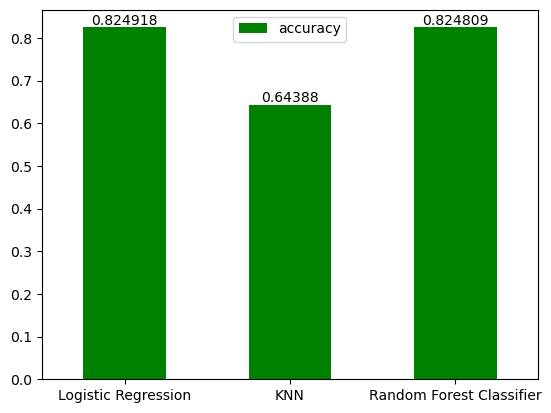

In [4]:
models_df = pd.DataFrame(data = model_scores.values(), index = model_scores.keys(), columns = ['accuracy'])
ax = models_df.plot(kind = 'bar', color = ['green'], rot=False)
for container in ax.containers:
    ax.bar_label(container=container,label_type='edge')

### Tuning hyperparameters 
For
* Logistic Regression
* Random Forest Classifier 

Using RandomizedSearchCV 

In [5]:
log_params = {
    'C':np.logspace(-4,4, 20),
    'solver':['liblinear']
}

rand_params = {
    "n_estimators": [100, 200, 300],   
    "max_depth": [None, 10, 20, 30],   
    "min_samples_split": [2, 5, 10],   
    "min_samples_leaf": [1, 2, 4],     
    "max_features": ["sqrt", "log2"],  
    "bootstrap": [True, False] 
}

log_cv = RandomizedSearchCV(LogisticRegression(max_iter=500), param_distributions=log_params, cv = 5, n_iter=200, verbose=True)
rand_cv = RandomizedSearchCV(RandomForestClassifier(), param_distributions=rand_params, n_iter=20, verbose=True, cv = 5)

log_cv.fit(X_train, y_train)
rand_cv.fit(X_train, y_train)




C:\Users\admin\Desktop\CODE\ML\sample_project_id_1\env\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 20 is smaller than n_iter=200. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,RandomForestClassifier()
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'max_features': ['sqrt', 'log2'], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,20
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [6]:
log_cv.best_params_, rand_cv.best_params_

({'solver': 'liblinear', 'C': np.float64(0.23357214690901212)},
 {'n_estimators': 100,
  'min_samples_split': 10,
  'min_samples_leaf': 1,
  'max_features': 'log2',
  'max_depth': 20,
  'bootstrap': True})

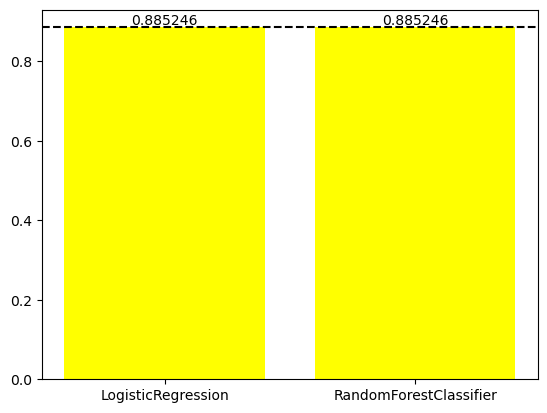

In [7]:
fig, ax = plt.subplots()

ax.bar(x=['LogisticRegression', 'RandomForestClassifier'], height=[log_cv.score(X_test, y_test), rand_cv.score(X_test, y_test)], color = 'yellow')
for container in ax.containers:
    ax.bar_label(container=container, label_type='edge')
ax.axhline(rand_cv.score(X_test, y_test), linestyle = '--', color = 'black')

>Based on results of the hyperparameters tuning we have selected Logistic Regression as the final model. 

## Evaluating our model
Using
* ROC Curve
* Confusion matrix
* Classification report
* Precision 
* Recall
* F1 score

#### ROC Curve and AUC

In [8]:
clf = log_cv

y_preds = clf.predict(X_test)
y_score = clf.predict_proba(X_test)
y_preds,y_score

(array([0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0]),
 array([[0.87279281, 0.12720719],
        [0.24438104, 0.75561896],
        [0.18194449, 0.81805551],
        [0.94913682, 0.05086318],
        [0.10873317, 0.89126683],
        [0.12414506, 0.87585494],
        [0.39656891, 0.60343109],
        [0.99608744, 0.00391256],
        [0.98761472, 0.01238528],
        [0.44643133, 0.55356867],
        [0.2775678 , 0.7224322 ],
        [0.88637493, 0.11362507],
        [0.10926503, 0.89073497],
        [0.94497552, 0.05502448],
        [0.03000753, 0.96999247],
        [0.06644782, 0.93355218],
        [0.03351399, 0.96648601],
        [0.90955659, 0.09044341],
        [0.98401135, 0.01598865],
        [0.97564621, 0.02435379],
        [0.28456166, 0.71543834],
        [0.97536919, 0.02463081],
        [0.85819712, 0.14180288],
        [

C:\Users\admin\Desktop\CODE\ML\sample_project_id_1\env\Lib\site-packages\sklearn\utils\_plotting.py:379: FutureWarning: `estimator_name` is deprecated in 1.7 and will be removed in 1.9. Use `name` instead.
  warnings.warn(
C:\Users\admin\Desktop\CODE\ML\sample_project_id_1\env\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


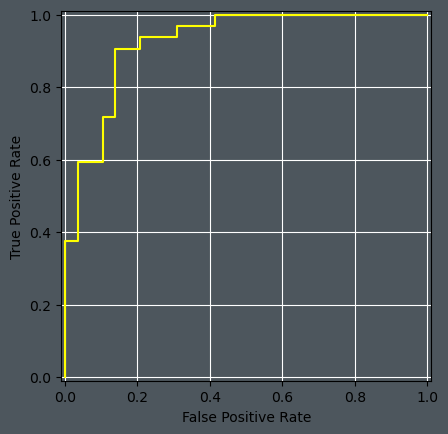

In [9]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('#4d565d')
ax.set_facecolor('#4d565d')


fpr, tpr, threshold = metrics.roc_curve(y_test, y_score[:, 1])
roc_auc_score = metrics.roc_auc_score(y_test, y_score[:,1])
roc_auc = metrics.auc(fpr, tpr)
display = RocCurveDisplay(estimator_name=clf, fpr=fpr, tpr = tpr, roc_auc=roc_auc)

display.plot(ax=ax, label = f'roc_auc_score: {roc_auc_score}', color = 'yellow')
ax.get_legend().remove()
ax.grid(visible=True, color = 'white')
plt.show()

#### Confusion matrix

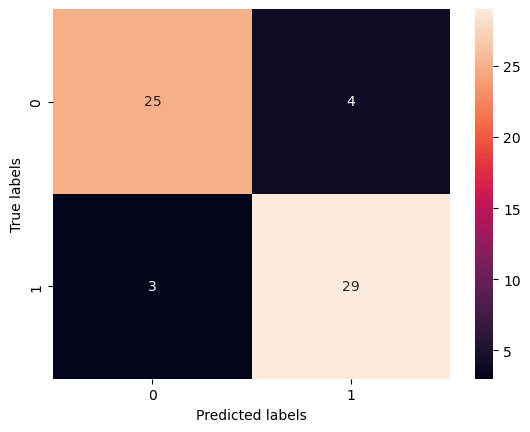

In [10]:
fig, ax = plt.subplots()

ax = sns.heatmap(confusion_matrix(y_pred=y_preds, y_true=y_test), annot = True)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.plot()
plt.show()

In [11]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88        29
           1       0.88      0.91      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.89        61



In [12]:
log_cv.best_params_

{'solver': 'liblinear', 'C': np.float64(0.23357214690901212)}

In [27]:
clf = LogisticRegression(**log_cv.best_params_)
scoring = ['accuracy', 'precision', 'recall', 'f1']
results = cross_validate(estimator=clf, scoring=scoring, cv=5, X=x, y=y)
results = {'accuracy':results['test_accuracy'].mean(),
           'precision':results['test_precision'].mean(), 
           'recall':results['test_recall'].mean(),
           'f1_score':results['test_f1'].mean()
           }
results

{'accuracy': np.float64(0.8479781420765027),
 'precision': np.float64(0.8215873015873015),
 'recall': np.float64(0.9272727272727274),
 'f1_score': np.float64(0.8705403543192143)}

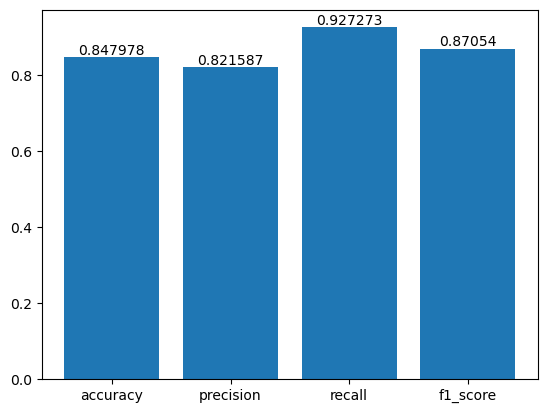

In [32]:
fig,ax = plt.subplots()

ax.bar(x=results.keys(), height = results.values())

for container in ax.containers:
    ax.bar_label(container=container, label_type='edge')

In [38]:
clf.fit(X_train,y_train)
clf.coef_[0]

array([ 0.00369922, -0.90424098,  0.67472823, -0.0116134 , -0.00170364,
        0.04787687,  0.33490208,  0.02472938, -0.63120414, -0.57590996,
        0.47095166, -0.65165344, -0.69984217])

<BarContainer object of 13 artists>

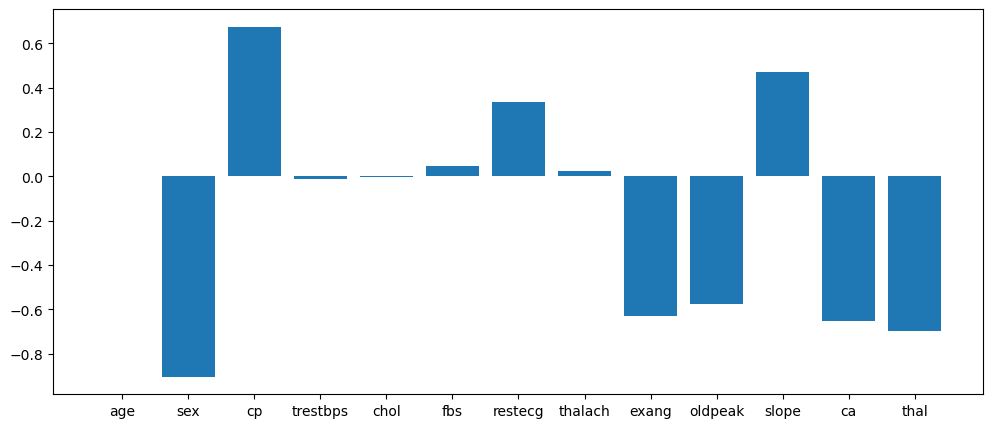

In [42]:
fig, ax = plt.subplots(figsize = (12,5))

ax.bar(x = x.columns, height=clf.coef_[0])

_The figure gives an idea on how each attribute contributes to model's predictions_

`The remainder of notebook is open to experimenatation. It is anticipated that incorporating additional data may contribute to improved model accuracy.`